The goal of this notebook is to implement the Bayesian LASSO method for a 1D problem.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import recipinvgauss
import scipy.sparse as sps
from scipy.sparse.linalg import cg

from fastprogress import progress_bar

from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

from runningstatistics import StatsTracker
import jlinops

# Make toy problem

In [2]:
ground_truth = jlinops.piecewise_constant_1d_test_problem()
n = len(ground_truth)
np.random.seed(0)
noise_stdev = 0.05
noise_var = noise_stdev**2
noisy_signal = ground_truth + noise_stdev*np.random.normal(size=n)
grid = np.arange(n)

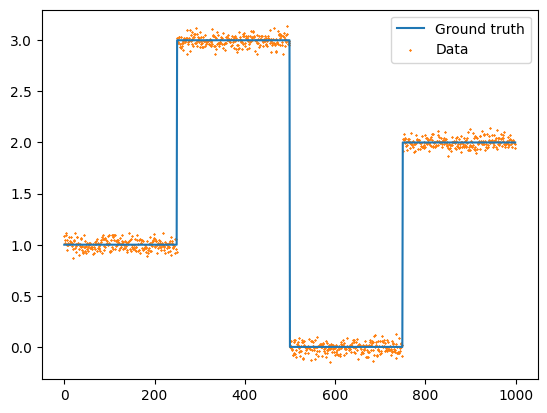

In [3]:
plt.plot(grid, ground_truth, label="Ground truth", color="C0")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

In [4]:
# Define forward operator and regularization matrix
F = jlinops.MatrixLinearOperator(sps.eye(n))
R, _ = jlinops.first_order_derivative_1d(n, boundary="none")
R = jlinops.MatrixLinearOperator(R)

# Set regularization lambda
reg_lambda = 1e2

# MAP estimate of the L1 problem

By L1 problem, I mean solving
$$
\operatorname{argmin}_x \left\{ \frac{1}{2 \sigma^2} \| x - y \|_2^2 + \lambda \| R x \|_1 \right\} = \operatorname{argmin}_x \left\{ \frac{1}{2} \| x - y \|_2^2 + (\lambda \sigma^2) \| R x \|_1 \right\}.
$$

In [5]:
# Solution is given by evaluating the proximal operator of the TV norm. This code uses a FDGP method
fdgp_map_result = jlinops.prox_tv1d_norm(noisy_signal, lam=noise_var*reg_lambda, iterations=1000)

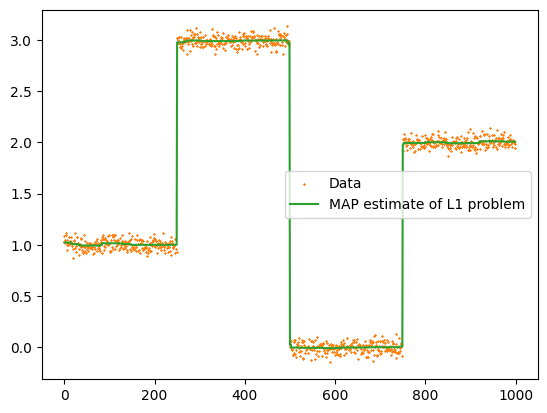

In [6]:
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.plot(grid, fdgp_map_result, label="MAP estimate of L1 problem", color="C2")
plt.legend()
plt.show()

In [7]:
# Solution is given by evaluating the proximal operator of the TV norm. This code uses a FDGP method
fdgp_map_result = jlinops.prox_tv1d_norm(noisy_signal, lam=noise_var*25, iterations=100)

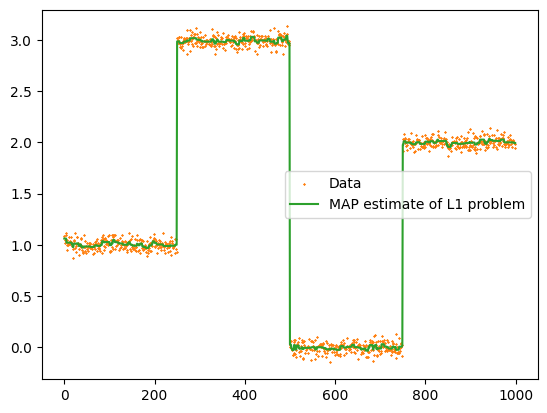

In [8]:
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.plot(grid, fdgp_map_result, label="MAP estimate of L1 problem", color="C2")
plt.legend()
plt.show()

# Sample the posterior of the Gaussian model

$$
-\log \pi(x)  = \left\{ \frac{1}{2 \sigma^2} \| x - y \|_2^2 + \frac{\lambda}{2} \| R x \|_2^2 \right\} + C
$$

In [9]:
def gauss_posterior_summary(F, R, y, noise_var=1.0, reg_lambda=1e1):
    """Computes posterior mean and stdev.
    """
    Q = sps.csc_matrix((1/noise_var)*(F.A.T @ F.A) + reg_lambda*(R.A.T @ R.A))
    Q = jlinops.MatrixLinearOperator(Q)
    Linv = jlinops.BandedCholeskyFactorInvOperator(Q)
    mean = Linv.T @ (Linv @  ((1/noise_var)*F.T @ y) )

    # Get diagonal entries of Qinv
    Qinv = Linv.T @ Linv
    var = jlinops.black_box_diagonal(Qinv)
    stdev = np.sqrt(var)
    return mean, stdev

In [10]:

gauss_mu, gauss_sigmas = gauss_posterior_summary(F, R, noisy_signal, noise_var=noise_var, reg_lambda=1e4)

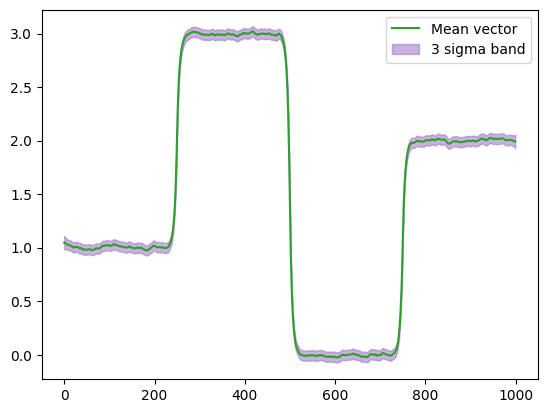

In [11]:
#plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.plot(grid, gauss_mu, label="Mean vector", color="C2")
plt.fill_between(grid, gauss_mu - 3*gauss_sigmas, gauss_mu + 3*gauss_sigmas, color="C4", alpha=0.5, label="3 sigma band")
plt.legend()
plt.show()

# Bayesian LASSO

In [39]:
class BayesianLASSOGibbsSampler:
    """Implements the Bayesian LASSO hierarchical sampler for the L1 problem.
    """

    def __init__(self, F, R, y, noise_var=1.0):

        self.F = F
        self.R = R
        self.y = y
        self.noise_var = noise_var
        self.noise_stdev = np.sqrt(noise_var)
        self.reg_lambda = reg_lambda
        
        self.m = F.shape[0]
        self.k = R.shape[0]
        self.n = R.shape[1]

        self.last_x_solve = None


    def sample(self, n_samples, x0=None, n_burn=0, theta_tol=1e-2, lam0=None, lam_update_freq=25, x_params={}):
        """Runs the Gibbs sampler.
        """

        # Initialize
        if x0 is None:
            x = np.zeros(self.F.shape[1])
        else:
            x = x0

        if lam0 is None:
            lam = 1.0
        else:
            lam = lam0

        # Create trackers
        x_tracker = StatsTracker(self.F.shape[1])
        theta_tracker = StatsTracker(self.R.shape[0])

        # For taking care of lambda udpates
        lam_update_fn = lambda theta_ss_est: np.sqrt( 2*self.R.shape[0]/theta_ss_est )
        theta_sum_tracker = StatsTracker((1,))
        lam_hist = [lam]
        theta_sums_all = []

        # For tracking when gaussian draws are accepted
        x_draws_accepted = 0

        # Run the sampler
        for j in progress_bar(range(n_samples+n_burn)):

            # Update theta
            theta = self.sample_theta(x, tol=theta_tol)

            # Update x
            x, accepted = self.sample_x(theta, x, **x_params)
            if j >= n_burn:
                if accepted:
                    x_draws_accepted += 1

            # For taking care of lambda updates
            theta_sums_all.append(theta.sum())
            theta_sum_tracker.push(theta.sum())

            if (j < n_burn) and (j%lam_update_freq == 0):

                # Get new lambda
                lam = lam_update_fn(theta_sum_tracker.mean()[0])
                lam_hist.append(lam)

                # Reset theta sum tracker
                theta_sum_tracker = StatsTracker((1,))
                
            # Push to tracker
            if j >= n_burn:
                x_tracker.push(x)
                theta_tracker.push(theta)


        results = {
            "x_tracker": x_tracker,
            "theta_tracker": theta_tracker,
            "lam_hist": np.asarray(lam_hist),
            "theta_sums_all": np.asarray(theta_sums_all),
            "x_draws_acceptance_rate": x_draws_accepted/n_samples,
        }

        return results


    def sample_x(self, theta, x_old, cg_maxits=None, cg_tol=1e-3, ar_step=True):
        """Given local variances theta, draws a sample for x.
        """


        # Update using RJPO method
        if cg_maxits is None:
            cg_maxits = self.n
        
        # Sample eta
        Ls = [ (1.0/self.noise_stdev)*self.F.T, self.R.T @ jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta))) ]
        Qmu = (1.0/self.noise_var)*(self.F.T @ self.y)
        eta = self.sample_eta(Qmu, Ls)

        # Solve system approximately
        Q = (1.0/self.noise_var)*(self.F.T @ self.F) + (self.R.T @ ( jlinops.MatrixLinearOperator(sps.diags(1.0/theta)) @ self.R ) )
        if self.last_x_solve is None:
            warmstart = None
        else:
            warmstart = - self.last_x_solve
        x_approx, _ = cg(Q, eta, x0=warmstart, maxiter=cg_maxits, tol=cg_tol)
        
        if not ar_step:
            return x_approx, True

        # x_approx = x_approx_solve["x"]
        # tot_cg_its += x_approx_solve["iterations"]

        # Compute residual
        # print(eta)
        # print(Q @ x_approx)
        #print(x_approx)
        residual = eta - (Q @ x_approx)

        # Accept or reject
        log_uniform = np.log(np.random.uniform())
        log_accept = np.amin([0.0, -residual.T @ (x_old - x_approx)])

        if log_uniform < log_accept:
            x = x_approx
            accepted = True
        else:
            x = x_old
            accepted = False

        self.last_x_solve = x

        return x, accepted

    

    def sample_theta(self, x, tol=1e-2):
        """Given x, draws a sample for the thetas.
        """

        # Get Rx
        Rx = self.R @ x

        # Make output array
        sample = np.zeros(self.R.shape[0])


        # Need to check where Rx is close to zero, so we can sample from exponential there instead
        idx_too_small = np.where(np.abs(Rx) < tol)
        idx_fine = np.where(np.abs(Rx) >= tol)

        # Break into two parts
        Rx_too_small = Rx[idx_too_small]
        Rx_fine = Rx[idx_fine]

        # For the components near zero, sample from the exponential
        theta_from_too_small = np.random.exponential(scale=1.0/self.reg_lambda, size=len(Rx_too_small))

        # For the components not near zero, sample from the inverse Gaussian
        theta_from_fine = recipinvgauss.rvs(mu=1.0/(self.reg_lambda*np.abs(Rx_fine)), scale=1.0/(self.reg_lambda**2))

        # Put all into one array
        sample[idx_too_small] = theta_from_too_small
        sample[idx_fine] = theta_from_fine

        assert np.all(sample > 0), "some thetas are no positive!"

        return sample


    def sample_eta(self, Qmu, Ls):
        """Draws a sample from $\mathcal{N}(Q \mu, Q)$. Here $Q$ is assumed to be of the form $Q = \sum_{i=1}^p L_i^T L_i$,
        where the $L_i$ are collected in Ls."""
         
        # Draw sample with correct covariance
        sample = np.zeros(self.n)
        for L in Ls:
            sample += L.matvec( np.random.normal(size=L.shape[1]) )

        # Add mean
        sample += Qmu
        
        return sample

In [50]:
lasso_sampler = BayesianLASSOGibbsSampler(F, R, noisy_signal, noise_var=noise_var)

In [125]:
sampling_result = lasso_sampler.sample(n_samples=300, n_burn=500, lam0=100*reg_lambda, 
                                        lam_update_freq=50, x_params={"cg_maxits":30, "cg_tol":1e-3, "ar_step":False})

In [126]:
sampling_result["x_draws_acceptance_rate"]

1.0

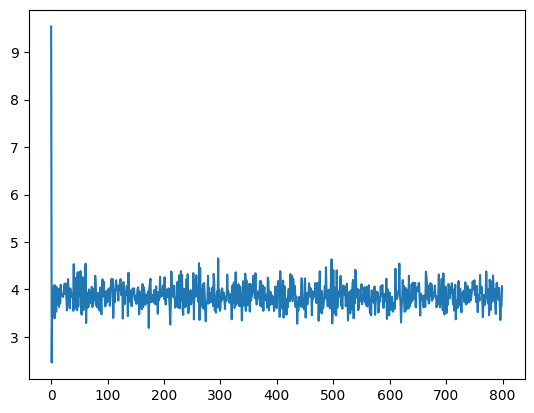

In [127]:
plt.plot(sampling_result["theta_sums_all"])
plt.show()

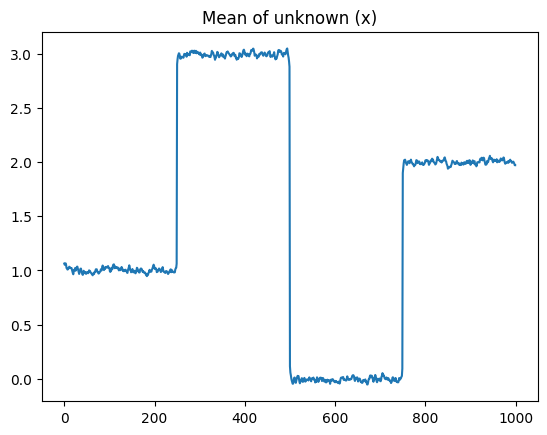

In [128]:
plt.plot(sampling_result["x_tracker"].mean())
plt.title("Mean of unknown (x)")
plt.show()

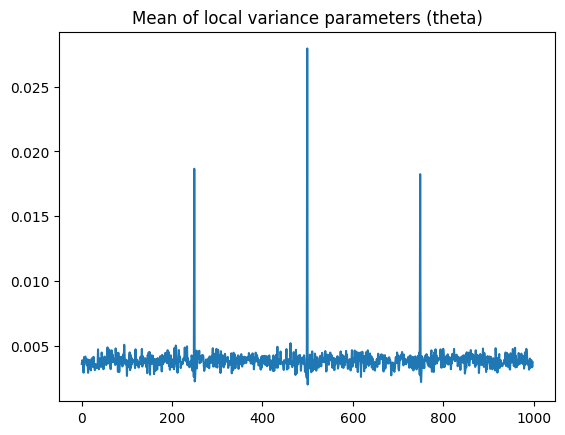

In [129]:
plt.plot(sampling_result["theta_tracker"].mean())
plt.title("Mean of local variance parameters (theta)")
plt.show()

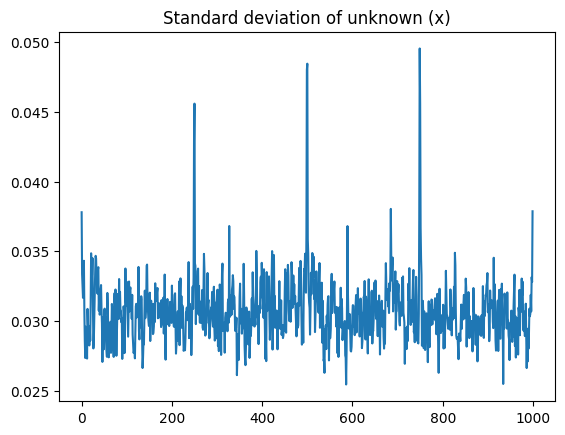

In [130]:
plt.plot(sampling_result["x_tracker"].stdev())
plt.title("Standard deviation of unknown (x)")
plt.show()

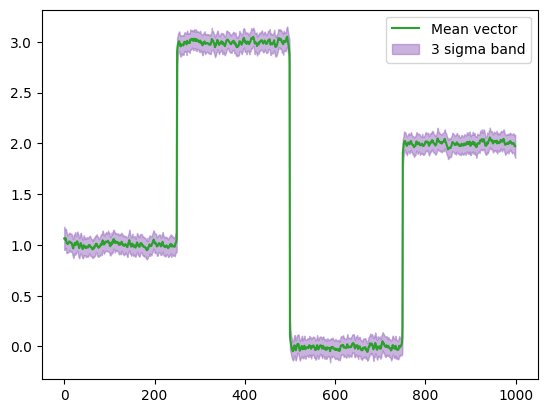

In [131]:
#plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
mu, stdev = sampling_result["x_tracker"].mean(), sampling_result["x_tracker"].stdev()
plt.plot(grid, mu, label="Mean vector", color="C2")
plt.fill_between(grid, mu - 3*stdev, mu + 3*stdev, color="C4", alpha=0.5, label="3 sigma band")
plt.legend()
plt.show()

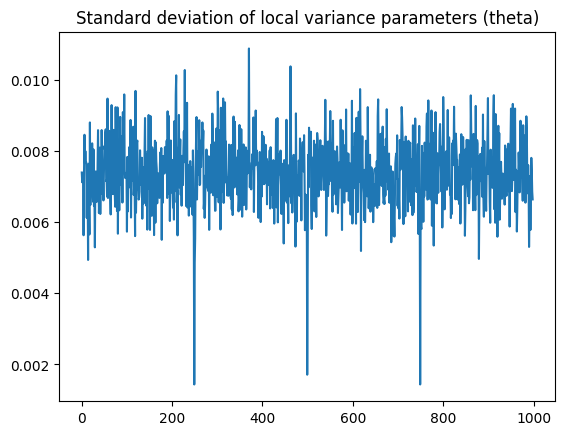

In [133]:
plt.plot(sampling_result["theta_tracker"].stdev())
plt.title("Standard deviation of local variance parameters (theta)")
plt.show()

# Comparison with other methods

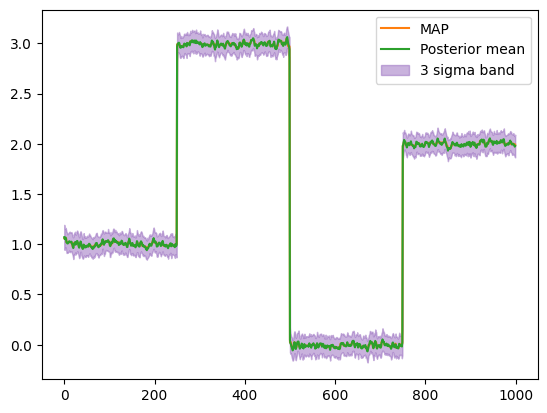

In [80]:
# Get MAP point for the lambda chosen during sampling
fdgp_map_result = jlinops.prox_tv1d_norm(noisy_signal, lam=noise_var*sampling_result["lam_hist"][-1], iterations=1000)
#plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)

mu, stdev = sampling_result["x_tracker"].mean(), sampling_result["x_tracker"].stdev()

plt.plot(grid, fdgp_map_result, label="MAP", color="C1")
plt.plot(grid, mu, label="Posterior mean", color="C2")
plt.fill_between(grid, mu - 3*stdev, mu + 3*stdev, color="C4", alpha=0.5, label="3 sigma band")
plt.legend()
plt.show()


[]

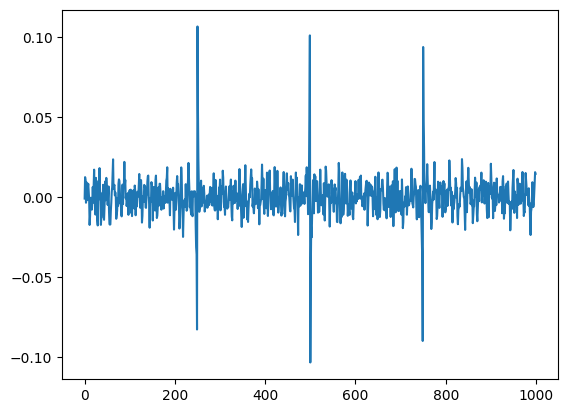

In [71]:
plt.plot( fdgp_map_result - mu )
plt.plot()